# PSFam docs

This doc will give instructions on how to use the PSFam file. The point of this code is to create an object which organizes Pauli Strings into commuting families, and computes the measurement basis at the same time so that it can be done quickly and without thinking about it. We will go through the process of making measurements of one family by the end of this doc. 

Hopefully I can get to an actual VQE example calculation, but that will take more study and overhead. I currently don't know how to do that, so it will come soon. This will only show how to use the built-in functions.

First things first, you'll need numpy and qiskit, so lets import those:

In [139]:
from Psfam import *
import numpy as np
from qiskit import *

Now pick the number of qubits, and assign this to $m$. Our basic object is Pauli_organizer, and it takes only the number of qubits as an argument. Once the object is initialized, it already has the families sorted. We can look at the properties of the object using properties(). This will tell us what $A$ matrix was used to generate all of the families. 

In [140]:
m=3
PO = Pauli_organizer(m)

print(PO.properties())

Qubits: 3
Generating vector: 1
Generating Matrix:
[0, 1, 0]
[1, 0, 1]
[0, 1, 1]


We can get all of the families with the get_families() function. This will return a list of family objects. There should be a list of $2^m + 1$ objects. The final 2 objects will be the x and z families. 

For normal families, there will be a permutation which generates the family, and the generating matrix $A^i$ can be printed from that permutation. The following methods can be used to get the individual properties. The to_string() function gives you the list of strings in the family.

The coefficients of the family will tell you how to calculate the measurement at the end. These would be the coefficients of the contribution of this family to the expectation value of the Hamiltonian:

$$
\langle H \rangle = \sum_i \alpha_i |\langle \psi | U | \chi_i \rangle |^2 + ...
$$

Since we have not entered the decomposition of the Hamiltonian, these can't be calculated yet

In [141]:
fam = PO.get_families()[2**m]

print(fam.to_string())
print(fam.get_permutation())
print(fam.get_generating_matrix())
print(fam.get_coefficients())

['IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ']
False
False
unassigned


This information can also be accessed using properties()

In [142]:
print(fam.properties())

z family
Qubits: 3
Coefficients: unassigned


This part can be skipped if you wish to calculate your coefficients differently. Suppose we have decomposed our Hamiltonian into pauli strings. This function I wrote to simulate this. It generates a dictionary with the decomposition of the hamiltonian into each Pauli string. $H = \sum \beta_i P_i$, and the dictionary is $\{ P_i : \beta_i \}$

In [143]:
def gen_random_pauli_dict(m):
    pauli_dict = dict()
    cp = ['I']*m
    coords = ([0]*m,[0]*m)
    pauli_dict["".join(cp)] = np.random.random()
    for i in range(4 ** m):
        coords = increment_coords(coords,m - 1)
        cp = increment_string(cp,m - 1)
        pauli_dict["".join(cp)] = np.random.random()
    return pauli_dict

decomp = gen_random_pauli_dict(m)
decomp

{'III': 0.3286148019009817,
 'IIZ': 0.9917591071666828,
 'IIX': 0.3258549644087967,
 'IIY': 0.4935045792350383,
 'IZI': 0.5724013088716127,
 'IZZ': 0.990548735501393,
 'IZX': 0.14366289274028898,
 'IZY': 0.21900810771499757,
 'IXI': 0.32063540122698597,
 'IXZ': 0.5672544285434643,
 'IXX': 0.3970483387647711,
 'IXY': 0.7602321843438941,
 'IYI': 0.1910196609284387,
 'IYZ': 0.3361863994198063,
 'IYX': 0.4532109600382208,
 'IYY': 0.4178757348954675,
 'ZII': 0.1423439279647003,
 'ZIZ': 0.7638359227859612,
 'ZIX': 0.47649145072889254,
 'ZIY': 0.7033166168298755,
 'ZZI': 0.585660669645874,
 'ZZZ': 0.9237179674877578,
 'ZZX': 0.9350659449084032,
 'ZZY': 0.7212643963420107,
 'ZXI': 0.3990291753391424,
 'ZXZ': 0.4171316684913584,
 'ZXX': 0.3340275136062557,
 'ZXY': 0.8396609348049963,
 'ZYI': 0.7007693974264649,
 'ZYZ': 0.1534109339962686,
 'ZYX': 0.8038669603874954,
 'ZYY': 0.14472372119578647,
 'XII': 0.3400675904532682,
 'XIZ': 0.3243419339543382,
 'XIX': 0.8244374516393774,
 'XIY': 0.0096778

Use the input_pauli_decomps() function to input this into the Hamiltonian. Then, the calc_coefficients() function calculates all the coefficients of the families, and returns the set of families for convenience. Now, when we read the properties of the family, the coefficients are calculated:

In [144]:
PO.input_pauli_decomps(decomp)
f = PO.calc_coefficients()
fam1 = f[0]
print(fam1.properties())
print(fam1.to_string())

Qubits: 3
Permutation:[3, 5, 6, 2, 1, 7, 4]
Coefficients: [3.892946114543429, -0.6122539020931762, -0.03210522960751827, -1.043895398504699, -1.296481117743424, 0.47656897018308897, -0.036607543303878276, -0.7395970104923563]
Generating Matrix:
[0, 1, 1]
[1, 0, 1]
[0, 1, 0]
['IXY', 'XZX', 'XYZ', 'ZXI', 'ZIY', 'YYX', 'YZZ']


Now lets make a sample measurement. Variational forms are not my strong area, so I made a sample fake variational form with random coefficients here:

In [145]:
def random_v_form(qc):
    rvs = []
    for i in range(3*m):
        rvs = rvs + [np.random.random()*2*pi]
    for i in range(m):
        qc.u(rvs[i],rvs[i+1],rvs[i+2],i)

The family object has a method apply_to_circuit() which automatically applies the correct unitary to the circuit. We will create a circuit which has a variational form, a unitary matrix, and a measurement at the end.

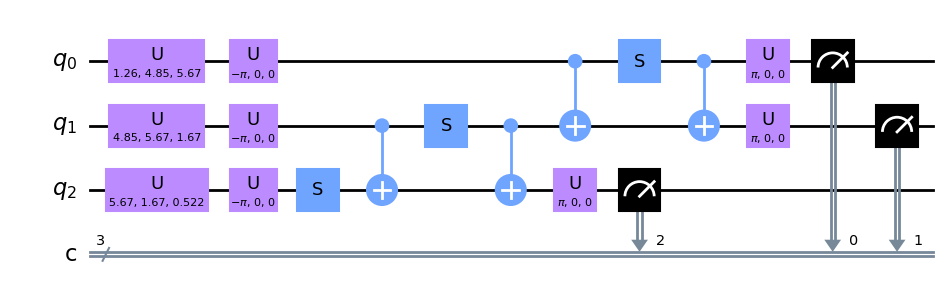

In [146]:
qc = qiskit.QuantumCircuit(m,m)

random_v_form(qc)
fam1.apply_to_circuit(qc)
#qc.barrier(range(m))
qc.measure(range(m), range(m))

qc.draw('mpl')

This code is straight from here: https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html. qiskit has methods to visualize the results.

In [147]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

{'001': 184, '010': 243, '000': 341, '011': 156, '111': 15, '110': 32, '100': 33, '101': 20}


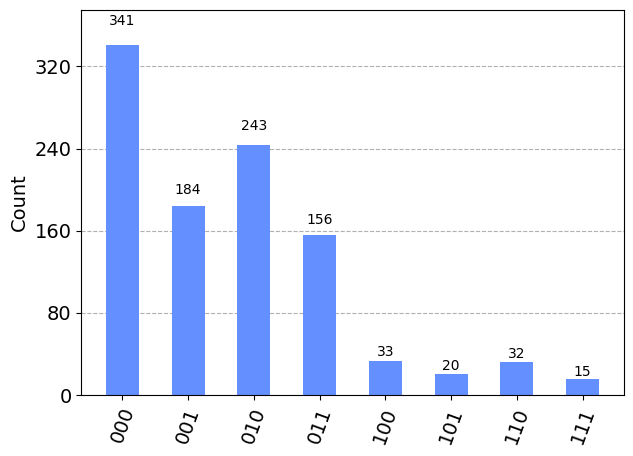

In [148]:
counts = result_sim.get_counts(qc)
print(counts)
qiskit.visualization.plot_histogram(counts)

Now that we have this result, we can use the counts of each result to get the probability of getting that result:

$$
P(010) = |\langle \psi | U | 010 \rangle |^2
$$

So we can just multiply these by the corresponding coefficients. The coefficients are in ascending binary order. The measurement for this family is calculated below:

In [149]:
cfs = fam1.get_coefficients()
measurement = 0

for i in range(2**m):
    bi = bin(i)[2:]
    while(len(bi)<m):
        bi = '0' + bi
    if(bi in counts):
        measurement = measurement + counts[bi]*cfs[i]/1024

print(measurement)

0.975266367273266


Now this is repeated for each family and all of the results are added together